In [103]:
# Импорт библиотек
import pandas as pd
import numpy as np
import random
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import scipy as sp
pd.options.mode.chained_assignment = None  # default='warn
%matplotlib inline


**Важно определить, какие технические показатели качества связи сильнее всего влияют на удовлетворённость клиентов, и в первую очередь направить ресурсы на работу с ними.**

In [104]:
data = pd.read_csv('megafon.csv')  # Загрузка данных


In [105]:
data.head(3)  # Cтруктура данных


,user_id,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms)
0,1,5,NaN,775.48846,360.13,86.56,3.93,1859.15,2309,1007.82,83
1,2,5,4,861.96324,3023.54,411.18,1.27,667.47,2080,255.36,425
2,3,1,4,261.11860,790.96,34.20,1.79,1079.60,6367,535.85,485


**user_id** — идентификатор абонента;

**Q1 — ответ на первый вопрос** В ходе опроса компания «Мегафон» предложила своим клиентам оценить уровень удовлетворённости качеством связи по десятибалльной шкале (где 10 — это «отлично», а 1 — «ужасно»). Если клиент оценивал качество связи на 9 или 10 баллов, опрос заканчивался;

**Q2 - ответ на второй вопрос** ; Если клиент ставил оценку ниже 9, задавался второй вопрос — о причинах неудовлетворённости качеством связи с предоставленными пронумерованными вариантами ответа. Ответ можно было дать в свободном формате или перечислить номера ответов через запятую:
1. Недозвоны, обрывы при звонках
2. Время ожидания гудков при звонке
3. Плохое качество связи в зданиях, тц и т.д.
4. Медленный мобильный интернет
5. Медленная загрузка видео
6. Затрудняюсь ответить
7. Свой вариант

**Total Traffic(MB)** — объем трафика передачи данных, насколько активно абонент использует мобильный интернет;

**Downlink Throughput(Kbps)** — средняя скорость «к абоненту», считается по всему трафику передачи данных;

**Uplink Throughput(Kbps)**— средняя скорость «от абонента», считается по всему трафику передачи данных;

**Downlink TCP Retransmission Rate(%)** — частота переотправок пакетов «к абоненту», чем выше, тем хуже. Если в канале возникает ошибка, пакет переотправляется. Снижается полезная скорость;

**Video Streaming Download Throughput(Kbps)** — скорость загрузки потокового видео, чем выше, тем лучше — меньше прерываний и лучше качество картинки;

**Video Streaming xKB Start Delay(ms)** — задержка старта воспроизведения видео, cколько времени пройдёт между нажатием на кнопку Play и началом воспроизведения видео. Чем меньше это время, тем быстрее начинается воспроизведение;

**Web Page Download Throughput(Kbps)** — скорость загрузки web-страниц через браузер, чем выше, тем лучше;

**Web Average TCP RTT(ms)** — пинг при просмотре web-страниц, чем меньше, тем лучше — быстрее загружаются web-страницы.

Первый технический показатель представлен как сумма за период в одну неделю перед участием в опросе. Остальные технические показатели отображают среднее значение по данному признаку за период в одну неделю перед участием в опросе.

### Предобработка данных ###

In [106]:
data.info() # Непустые значения в колонках


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3112 entries, 0 to 3111
Data columns (total 11 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   user_id                                    3112 non-null   int64  
 1   Q1                                         3110 non-null   object 
 2   Q2                                         1315 non-null   object 
 3   Total Traffic(MB)                          3112 non-null   float64
 4   Downlink Throughput(Kbps)                  3112 non-null   float64
 5   Uplink Throughput(Kbps)                    3112 non-null   float64
 6   Downlink TCP Retransmission Rate(%)        3112 non-null   float64
 7   Video Streaming Download Throughput(Kbps)  3112 non-null   float64
 8   Video Streaming xKB Start Delay(ms)        3112 non-null   int64  
 9   Web Page Download Throughput(Kbps)         3112 non-null   float64
 10  Web Average TCP RTT(ms) 

**Работа с переменной Q1 - ответ на первый вопрос, возможные значения 1-10**

In [107]:
data['Q1'].value_counts() # Имеющиеся значения и их количество


10                                                                      846
1                                                                       532
3                                                                       325
8                                                                       291
9                                                                       238
5                                                                       234
7                                                                       200
2                                                                       168
4                                                                       123
6                                                                       101
0                                                                        10
Да                                                                        2
1, 3                                                                      2
Нет         

In [108]:
data['user_id'] = data['user_id'].astype(str) 
# Удалим ошибочные и пропущенные значения с ответом на первый вопрос
data['Q1'] = data['Q1'].astype('str')
data['Q1'] = [elem if elem in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
                    else np.NaN for elem in data['Q1']]
data.dropna(subset=['Q1'], inplace=True)
data['Q1'].value_counts()


10    846
1     532
3     325
8     291
9     238
5     234
7     200
2     168
4     123
6     101
Name: Q1, dtype: int64

**Разделим абонентов на группы и создадим метки группы для всех абонентов - A: оценка (9-10), B: оценка (5-8), C: оценка (1-4)**

In [109]:
data['Group'] = data['Q1']


In [110]:
data['Group'] = ['A' if elem in ['9', '10'] else 'B' if elem
                    in ['5', '6', '7', '8'] else 'C' for elem in data['Group']]


In [111]:
data['Group'].value_counts()  # Количество абонентов по группам


C    1148
A    1084
B     826
Name: Group, dtype: int64

In [112]:
#  Изменим порядок колонок в датасете

cols = ['user_id', 'Group', 'Q1', 'Q2', 'Total Traffic(MB)',
        'Downlink Throughput(Kbps)', 'Uplink Throughput(Kbps)',
        'Video Streaming Download Throughput(Kbps)', 'Web Page Download Throughput(Kbps)',
        'Downlink TCP Retransmission Rate(%)', 'Video Streaming xKB Start Delay(ms)',
        'Web Average TCP RTT(ms)']
data = data[cols]
data.head(1)


,user_id,Group,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Video Streaming Download Throughput(Kbps),Web Page Download Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming xKB Start Delay(ms),Web Average TCP RTT(ms)
0,1,B,5,NaN,775.48846,360.13,86.56,1859.15,1007.82,3.93,2309,83


In [113]:
# Т.к. отсутствующие значения остались только в колонке Q2, проставим ответ 6 (затрудняюсь ответить) для пустых значений
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3058 entries, 0 to 3111
Data columns (total 12 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   user_id                                    3058 non-null   object 
 1   Group                                      3058 non-null   object 
 2   Q1                                         3058 non-null   object 
 3   Q2                                         1315 non-null   object 
 4   Total Traffic(MB)                          3058 non-null   float64
 5   Downlink Throughput(Kbps)                  3058 non-null   float64
 6   Uplink Throughput(Kbps)                    3058 non-null   float64
 7   Video Streaming Download Throughput(Kbps)  3058 non-null   float64
 8   Web Page Download Throughput(Kbps)         3058 non-null   float64
 9   Downlink TCP Retransmission Rate(%)        3058 non-null   float64
 10  Video Streaming xKB Star

In [114]:
data[data['Group'] != 'A'] = data[data['Group'] != 'A'].fillna('6')


In [115]:
data[(data['Q1'] == '9') | (data['Q1'] == '10')][['Q2']].shape[0]  # Проверим количество строк группы A


1084

In [116]:
data[(data['Q1'] == '9') | (data['Q1'] == '10')][['Q2']].isna().sum()[0]
# Проверим пустые значения группы A на Q2 - совпадает


1084

In [117]:
data_Q1 = data.copy()


### Построение доверительных интервалов для оценки долей пользователей, которые полностью довольны качеством связи (группа A), и для пользователей, которые неудовлетворёны качеством связи (группы В и С) ###

Оценка данного показателя позволяет оценить общую картину удовлетворенности услугами компании "Мегафон" с целью дальнейшего анализа конкретных групп и показателей

In [118]:
data_Q1[['user_id']].duplicated().sum()  # Количество повторяющихся пользователей


0

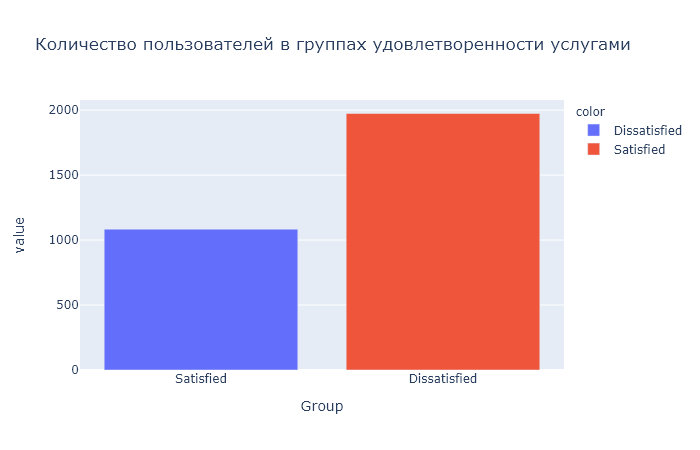

In [119]:
df1 = data_Q1.copy()
df1['Group'] = ['Satisfied' if elem == 'A' else 'Dissatisfied' for elem in df1['Group']]
fig = px.bar(df1.groupby(['Group'])[['user_id']].count().sort_values(by='user_id'),
       color=df1.groupby(['Group'])[['user_id']].count().index,
        title='Количество пользователей в группах удовлетворенности услугами', width=800)
fig.show("png")

**Расчет доверительного интервала для доли пользователей полностью удовлетворенными качеством связи (Ответ 9,10 на первый вопрос) генеральной совокупности пользователей компании 'Мегафон'**

In [120]:
df1 = pd.get_dummies(df1, columns=['Group']) 
# Конвертируем категориальную переменную для удобства группировки


In [121]:
from statsmodels.stats.proportion import proportion_confint

normal_interval1 = proportion_confint(sum(df1['Group_Satisfied']), len(df1['Group_Satisfied']), 
                                      method='normal')
print ('Доверительный интервал {} с шириной {}'.format(normal_interval1,
                                      round((normal_interval1[1] - normal_interval1[0]), 3)))


Доверительный интервал (0.3375257436900856, 0.37143436095347226) с шириной 0.034


**Расчет доверительного интервала для доли пользователей неудовлетворенными качеством связи (Ответ 1-8 на первый вопрос) генеральной совокупности пользователей компании 'Мегафон'**

In [122]:
normal_interval2 = proportion_confint(sum(df1['Group_Dissatisfied']), 
                                      len(df1['Group_Dissatisfied']), method='normal')
print ('Доверительный интервал {} с шириной {}'.format(normal_interval2, 
                                                round((normal_interval2[1] - normal_interval2[0]), 3)))


Доверительный интервал (0.6285656390465277, 0.6624742563099144) с шириной 0.034


**С вероятностью в 95% доля пользователей полностью удовлетворенными качеством связи компании 'Мегафон' лежит в промежутке (0.3375; 0.3714), доля пользоваталей неудовлетворенными качеством связи лежит в промежутке (0.6286; 0.6625)**

Построим график полученных долей и интервалов для них

<function matplotlib.pyplot.show(close=None, block=None)>

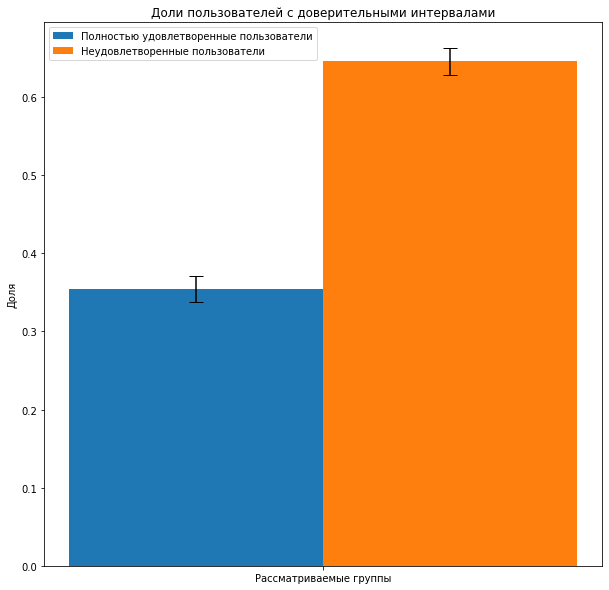

In [123]:
labels = ['Рассматриваемые группы']
Group_Satisfied_prop = sum(df1['Group_Satisfied'])/len(df1['Group_Satisfied'])
Group_Dissatisfied_prop = sum(df1['Group_Dissatisfied'])/len(df1['Group_Dissatisfied'])
yer1 = (normal_interval1[1] - normal_interval1[0])/2
yer2 = (normal_interval2[1] - normal_interval2[0])/2

x = np.arange(len(labels))
width = 0.35  

fig, ax = plt.subplots()
ax.bar(x - width/2, Group_Satisfied_prop, width, yerr=yer1, capsize=7,label='Полностью удовлетворенные пользователи')
ax.bar(x + width/2, Group_Dissatisfied_prop, width, yerr=yer2, capsize=7, label='Неудовлетворенные пользователи')

ax.set_ylabel('Доля')
ax.set_title('Доли пользователей с доверительными интервалами')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.gcf().set_size_inches(10, 10)
plt.show


Можем сделать вывод, что примерно 2/3 пользователей имеют некоторые проблемы со связью, следовательно нужно подробнее разбирать группы пользователей B и C

**Построение доверительного интервала для оценки доли пользователей, которые указали на проблемы по связью (ответы: 1,2,3; на второй вопрос), относительно всех пользователей**

Рассмотрение данного показателя в первую очередь важно, т.к. компания специализуруется на услугах голосовой связи и большинство пользователей указали на проблему именно с данной составляющей бизнеса

In [124]:
# Cоздание массива, разделенного по Q2, с наличием выбросов в числовых признаках для расчета доли
df2 = data_Q1.copy()

# Разделение нескольких ответов на список ответов
df2['Q2'] = df2['Q2'].str.replace(" ", "").str.split(',')
df2 = df2.explode('Q2')  # Q2 - ответ на первый вопрос, возможные значения 1-7, или несколько ответов

df2['Q2'] = [elem if elem in ['1', '2', '3', '4', '5', '6', '7', np.NaN]
                else 'error' for elem in df2['Q2']]
df2 = df2[df2['Q2'] != 'error']

# Заполним пропуски в Q2 для групп B и C нейтральным ответов
df2[df2['Group'] != 'A'] = df2[df2['Group'] != 'A'].fillna('6')

df2 = df2.reset_index(drop=True)


df2_1 = df2[(df2['Q2'] == '1') | (df2['Q2'] == '2') | (df2['Q2'] == '3')]  # Интересующие нас группы
df2_1 = df2_1.drop_duplicates(subset='user_id')  # Устранение повторяющихся пользователей внутри групп
df2_1


,user_id,Group,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Video Streaming Download Throughput(Kbps),Web Page Download Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming xKB Start Delay(ms),Web Average TCP RTT(ms)
3,4,B,8,3,179.18564,2590.97,325.88,7053.81,1221.02,0.80,3218,51
4,5,C,2,2,351.99208,731.61,223.54,4550.38,2336.56,1.15,1767,68
11,9,C,1,1,783.64464,1786.99,271.77,6802.42,1837.02,0.84,1200,132
14,10,C,3,1,455.97369,610.43,81.86,1317.76,1054.15,4.10,3350,165
18,11,C,3,1,526.08652,535.54,208.67,2621.14,2376.50,1.46,1479,88
...,...,...,...,...,...,...,...,...,...,...,...,...
4206,3103,B,8,1,413.99008,908.59,215.83,9449.73,2212.11,1.62,1467,51
4208,3105,C,1,1,206.28181,105.24,65.84,349.04,1035.69,3.86,2094,267
4213,3108,C,3,1,519.96475,1045.70,44.61,4523.66,1044.66,0.47,1468,304
4216,3109,C,3,1,171.52629,670.32,40.94,1711.54,954.91,2.35,2780,251


In [125]:
n = data_Q1.shape[0]  # Размер выборки
n


3058

In [126]:
p = df2_1.shape[0] / n # Построение интервала

se = np.sqrt(p * (1 - p) / n)

interv = np.round(st.norm.interval(0.95, loc=p, scale=se), 4)
print ('Доверительный интервал равен {} '.format(interv))


Доверительный интервал равен [0.3194 0.3529] 


Построение графика полученной доли с доверительным интервалом

<function matplotlib.pyplot.show(close=None, block=None)>

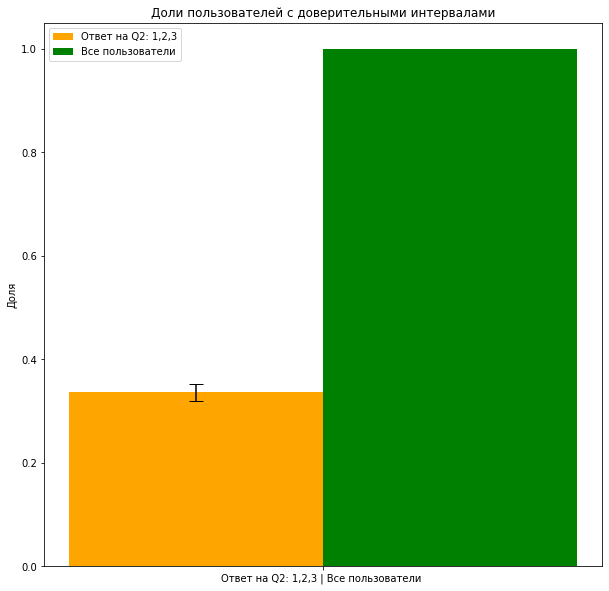

In [127]:
labels = ['Ответ на Q2: 1,2,3 | Все пользователи ']
Group_Satisfied_prop = len(df2_1) / data_Q1.shape[0]
yer1 = (interv[1] - interv[0]) / 2

x = np.arange(len(labels))  
width = 0.35 

fig, ax = plt.subplots()
ax.bar(x - width/2, Group_Satisfied_prop, width, yerr=yer1, capsize=7,label='Ответ на Q2: 1,2,3', color='orange')
ax.bar(x + width/2, 1, width,label='Все пользователи', color='green')

ax.set_ylabel('Доля')
ax.set_title('Доли пользователей с доверительными интервалами')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.gcf().set_size_inches(10, 10)
plt.show


**С вероятностью в 95% доля пользователей, которые указали на проблемы по связью (ответы: 1,2,3; на второй вопрос), относительно всех пользователей компании 'Мегафон' лежит в промежутке (0.3194, 0.3529]**

**Устранение выбросов в числовых признаках**

Следуя эвристики, что выбросы находятся за пределами следующих интервалов: Q1–1.5 x IQR и Q3 + 1.5 x IQR, преобразуем данные.

Q1 - Первый квартиль, равен 25-ому процентилю;

Q3 - Третий квартиль, равен 75-ому процентилю;

IQR - число, которое показывает разброс средней половины (т.е. средние 50%) набора данных и помогает определить выбросы, разница между Q3 и Q1;

In [128]:
col = data.describe().columns  # Колонки числовых атрибутов


In [129]:
Q1, Q3 = data_Q1[col].quantile(0.25), data_Q1[col].quantile(0.75)
IQR = Q3 - Q1
data_Q1_Out = data_Q1[~((data_Q1[col] < (Q1 - 1.5 * IQR)) | (data_Q1[col] >
                    (Q3 + 1.5 * IQR))).any(axis=1)]
data = data_Q1_Out


**Работа с переменной Q2 - ответ на первый вопрос, возможные значения 1-7, или несколько ответов**

In [130]:
data['Q2'].value_counts() # Возможные значения и их количество 


6                   451
3                   135
4                   100
1                    98
1, 3                 80
3, 4                 65
1, 3, 4              43
7                    39
1, 2, 3              31
1, 4                 29
1, 3, 4, 5           28
3, 4, 5              27
1, 2, 3, 4, 5        19
1, 2                 16
4, 5                 16
1, 2, 3, 4           13
1, 4, 5              13
3, 5                  7
2, 3, 4               7
2, 3                  7
1, 2, 4               7
2                     6
1, 5                  5
5                     4
1, 3, 5               3
1, 4, 7               3
2, 3, 4, 5            3
2, 4                  3
1, 2, 5               2
2, 4, 5               2
1, 2, 4, 5            2
1, 3, 4, 7            2
1, 3, 4, 5, 7         2
1, 2, 3, 4, 5, 6      1
0, 1, 7               1
3, 4, 5, 7            1
3, 7                  1
1, 2, 3, 5            1
1, 3, 7               1
0                     1
1, 2, 3, 7            1
0, 3            

In [131]:
# Для наблюдений с несколькими вариантами, уберем пробелы, переведем в списки и разобьем на отдельные наблюдения.
# Значения остальных атрибутов для таких наблюдений остаются неизменными.

In [132]:
data['Q2'] = data['Q2'].str.replace(" ", "").str.split(',')
data = data.explode('Q2')


In [133]:
data['Q2'] = [elem if elem in ['1', '2', '3', '4', '5', '6', '7', np.NaN]
                  else 'error' for elem in data['Q2']]
data = data[data['Q2'] != 'error']


In [134]:
data['Q2'].value_counts() # Финальное количество вариантов ответа на Q2


3    480
6    452
1    403
4    387
5    136
2    124
7     54
Name: Q2, dtype: int64

In [135]:
# Заполним пропуски в Q2 для групп B и C нейтральным ответов

data[data['Group'] != 'A'] = data[data['Group'] != 'A'].fillna('6')
data = data.reset_index(drop=True)
data_Q2 = data.copy()


<AxesSubplot:title={'center':'Корреляция признаков (Пирсон)'}>

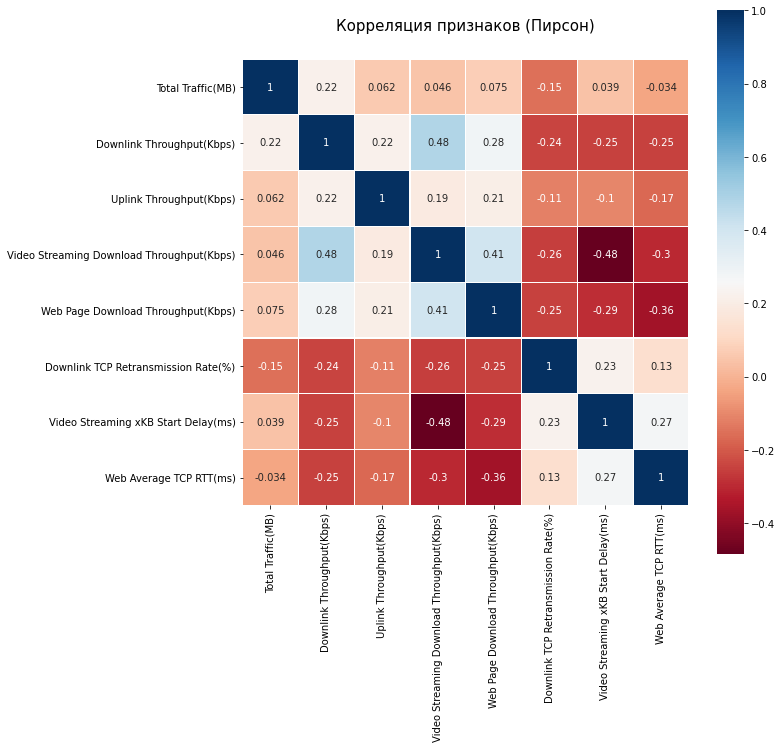

In [136]:
# Корреляция признаков

colormap = plt.cm.RdBu
plt.figure(figsize=(10,10))
plt.title('Корреляция признаков (Пирсон)', y=1.05, size=15)
sns.heatmap(data_Q2.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)


Сильная корреляция между рассматриваемыми величинами отсутсвует, наибольшее значение коэффициента **0.48** между **Video Streaming Download Throughput** и **Downlink Throughput**, **-0.48** между **Video Streaming Download Throughput** и **Video Streaming xKB Start Delay**, **0.41** между **Video Streaming Download Throughput** и **Web Page Download Throughput**.

**Рассмотрим меры центральной тенденции - среднее и медиану для групп пользователей разделенных по ответу на первый вопрос:**

Группы - A: оценка (9-10), B: оценка (5-8), C: оценка (1-4)

In [137]:
# Построение массивов кол-во наблюдений + значения показателей

Q1_mean_1 = data_Q1_Out.groupby(['Group'])[['user_id']].count()
Q1_mean_1.columns = ['user_id, count']
Q1_mean_2 = data_Q1_Out.groupby(['Group']).agg('mean') \
                       .sort_values(by='Group').round(2)
Q1_mean = pd.concat([Q1_mean_1, Q1_mean_2], axis=1)

Q1_median_1 = data_Q1_Out.groupby(['Group'])[['user_id']].count()
Q1_median_1.columns = ['user_id, count']
Q1_median_2 = data_Q1_Out.groupby(['Group']).agg('median') \
                         .sort_values(by='Group').round(2)

Q1_median = pd.concat([Q1_median_1, Q1_median_2], axis=1)

Q1_mean  # Средние значения для числовых показателей


,"user_id, count",Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Video Streaming Download Throughput(Kbps),Web Page Download Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming xKB Start Delay(ms),Web Average TCP RTT(ms)
Group,,,,,,,,,
A,700,412.30,1876.49,145.13,5371.52,1879.51,1.38,1696.58,131.57
B,547,424.04,1842.24,144.26,5260.61,1824.31,1.49,1768.55,138.85
C,734,416.21,1662.22,137.44,4708.80,1707.93,1.58,1855.18,149.55


In [138]:
Q1_median  # Медианные значения для числовых показателей


,"user_id, count",Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Video Streaming Download Throughput(Kbps),Web Page Download Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming xKB Start Delay(ms),Web Average TCP RTT(ms)
Group,,,,,,,,,
A,700,365.00,1519.74,120.80,4821.22,1769.54,1.20,1572.5,105.5
B,547,389.35,1366.61,119.43,4623.44,1666.18,1.28,1655.0,114.0
C,734,377.32,1293.52,116.33,4109.82,1576.06,1.32,1694.0,127.5


Показатели: Total Traffic(MB) - из опрошенных мобильный интернет активнее всего используется пользователями группы 'B';

Downlink Throughput(Kbps),Uplink Throughput(Kbps), Video Streaming Download Throughput(Kbps), Web Page Download Throughput(Kbps) - наибольшие показатели скорости загрузки у пользователей группы 'A', наименьшие у группы 'C'; 

Downlink TCP Retransmission Rate(%)(частота переотправок пакетов «к абоненту»),Video Streaming xKB Start Delay(ms)(задержка старта воспроизведения видео),Web Average TCP RTT(ms)(пинг при просмотре web-страниц) - наименьшие (наилучшие) показатели у пользователей группы 'A', наибольшие (наихудшие) - у группы 'C';

В целом, основываясь на рассмотренных выборках, имеется предположение, что разница в показателях пользователей группы 'A' и группы 'B' различаются меньше, чем разница в показателях группы 'B' и 'C'.

**Рассмотрим меры центральной тенденции - среднее и медиану для групп пользователей разделенных по ответу на второй вопрос:**

1.Недозвоны, обрывы при звонках  
2.Время ожидания гудков при звонке  
3.Плохое качество связи в зданиях, тц и т.д.  
4.Медленный мобильный интернет  
5.Медленная загрузка видео  
6.Затрудняюсь ответить  
7.Свой вариант  

In [139]:
# Построение массивов кол-во наблюдений + значения показателей

Q2_mean_1 = data_Q2.groupby(['Q2'])[['user_id']].count()
Q2_mean_1.columns = ['user_id, count']
Q2_mean_2 = data_Q2.groupby(['Q2']).agg('mean') \
                   .sort_values(by='Q2').round(2)

Q2_mean = pd.concat([Q2_mean_1, Q2_mean_2], axis=1) 

Q2_median_1 = data_Q2.groupby(['Q2'])[['user_id']].count()
Q2_median_1.columns = ['user_id, count']
Q2_median_2 = data_Q2.groupby(['Q2']).agg('median').sort_values(by='Q2').round(2)

Q2_median = pd.concat([Q2_median_1, Q2_median_2], axis=1)

Q2_mean  # Средние для числовых показателей


,"user_id, count",Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Video Streaming Download Throughput(Kbps),Web Page Download Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming xKB Start Delay(ms),Web Average TCP RTT(ms)
Q2,,,,,,,,,
1,403,410.06,1787.28,145.94,5045.35,1756.82,1.59,1817.25,145.68
2,124,395.59,1654.47,140.41,4793.18,1770.88,1.56,1847.86,153.37
3,480,420.52,1728.35,141.19,4817.77,1769.04,1.62,1809.03,142.59
4,387,440.76,1661.62,135.53,4482.69,1648.09,1.59,1902.98,154.15
5,136,434.34,1447.95,131.38,3919.86,1613.10,1.58,1929.76,157.15
6,452,412.84,1684.16,142.23,5047.90,1769.47,1.50,1796.79,146.30
7,54,406.87,1753.45,138.13,4808.98,1803.71,1.52,1817.15,131.33


In [140]:
Q2_median  # Медианные значения для числовых показателей


,"user_id, count",Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Video Streaming Download Throughput(Kbps),Web Page Download Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming xKB Start Delay(ms),Web Average TCP RTT(ms)
Q2,,,,,,,,,
1,403,370.92,1361.30,119.45,4576.39,1589.45,1.37,1662.0,125.0
2,124,375.97,1095.54,116.10,4050.38,1628.90,1.32,1709.5,131.5
3,480,379.86,1314.74,121.15,4252.07,1644.94,1.34,1664.5,117.0
4,387,415.86,1155.32,118.53,3915.89,1498.28,1.36,1743.0,133.0
5,136,413.47,1108.19,104.55,3287.10,1430.19,1.33,1743.5,135.5
6,452,366.52,1265.22,116.13,4349.46,1641.42,1.27,1671.0,122.0
7,54,352.47,1543.91,124.46,4223.85,1513.76,1.39,1700.5,101.0


На первый взгляд - видимых различий не наблюдается, более детальные различия и гипотезы между данными группами далее будут проверены в ходе исследования

**Построение гистограмм распределений рассматривыемых признаков**

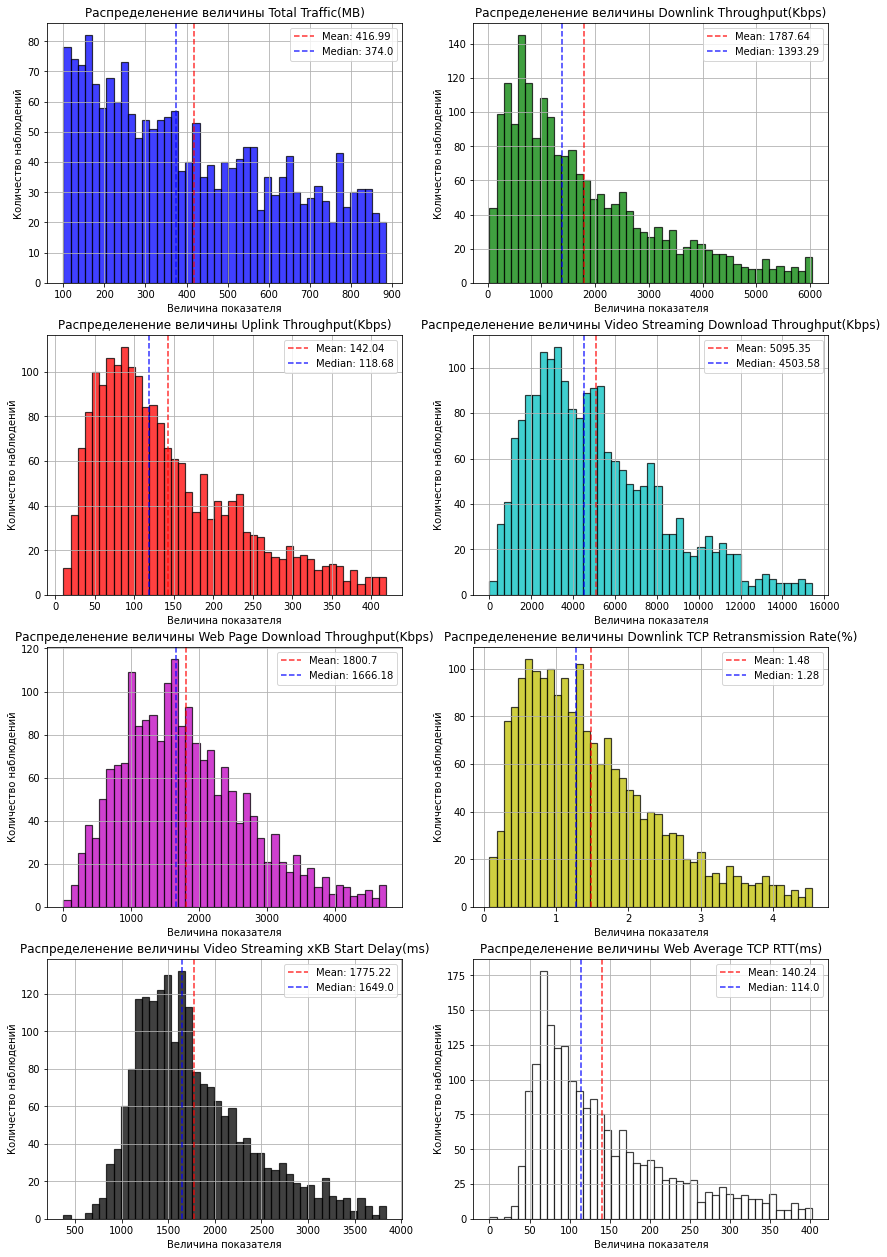

In [141]:
cols_par = ['Total Traffic(MB)',
        'Downlink Throughput(Kbps)', 'Uplink Throughput(Kbps)',
        'Video Streaming Download Throughput(Kbps)', 'Web Page Download Throughput(Kbps)',
        'Downlink TCP Retransmission Rate(%)', 'Video Streaming xKB Start Delay(ms)',
        'Web Average TCP RTT(ms)']

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'] # Список цветов граффиков

plt.figure(figsize=(14, 22)) 
for i, col in enumerate(cols_par): # Цикл для построения распределений числовых признаков
    plt.subplot(4, 2, i+1)
    plt.hist(data_Q1_Out[col], bins=45, facecolor=colors[i], 
             alpha=0.75, edgecolor='black', linewidth=1.2)
    plt.axvline(data_Q1_Out[col].mean(), color='red', alpha=0.8,
                linestyle='dashed', label='Mean: ' + str(round(data_Q1_Out[col].mean(), 2)))
    plt.axvline(data_Q1_Out[col].median(), color='blue', alpha=0.8, 
                linestyle='dashed', label='Median: ' + str(round(data_Q1_Out[col].median(), 2)))
    plt.xlabel('Величина показателя')
    plt.ylabel('Количество наблюдений')
    plt.grid(True)
    plt.title('Распределенение величины '  + col)
    plt.legend(loc='upper right')
    plt.show
    

**Выполним проверку полученных распределений на нормальность**

**Тест Шапиро-Уилка проверяет нулевую гипотезу о том, что выборка x 1 , ..., x n произошла из нормально распределенной ГС**

Если размер выборки достаточно велик (> 100), этот тест может обнаруживать даже тривиальные отклонения от нулевой гипотезы (т.е. хотя и может иметь место некоторый статистически значимый эффект , он может быть слишком мал, чтобы иметь какое-либо практическое значение)

In [142]:
for i, col in enumerate(cols_par):
    res = st.shapiro(np.log(data_Q1_Out[col]))
    print('_________________________________________')
    print(col, '\np_value: ', res[1])
    

_________________________________________
Total Traffic(MB) 
p_value:  1.0427532237684525e-24
_________________________________________
Downlink Throughput(Kbps) 
p_value:  6.657131475250867e-19
_________________________________________
Uplink Throughput(Kbps) 
p_value:  1.368848285589197e-12
_________________________________________
Video Streaming Download Throughput(Kbps) 
p_value:  1.0
_________________________________________
Web Page Download Throughput(Kbps) 
p_value:  1.0
_________________________________________
Downlink TCP Retransmission Rate(%) 
p_value:  3.3585777506963147e-16
_________________________________________
Video Streaming xKB Start Delay(ms) 
p_value:  6.48898756949734e-09
_________________________________________
Web Average TCP RTT(ms) 
p_value:  1.0


D:\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning:

divide by zero encountered in log



Полученные p-value либо сильно меньше допустимого уровня значимости (p = 0.05), либо равны 1, что свидетельствует о том, что есть все основания предполагать, что размер выборок достаточно велик, чтобы делать выводы о нормальности ГС рассматриваемых признаков

Если данные не имеют распределения Гаусса (Нормального) и дисперсия Генеральной Совокупности параметров неизвестна, мы должны прибегнуть к непараметрической версии тестов значимости.

Непараметрические критерии используются для следующих переменных:

**- для количественных переменных, распределение которых нельзя однозначно отнести к нормальному закону распределения; (наш случай)**
- для переменных, измеренных в порядковой шкале;
- для переменных, измеренных в номинальной шкале.

Непараметрические критерии могут применяться и в случае нормального распределения. В этом случае они будут иметь только 95%-ую эффективность по сравнению с параметрическими тестами.

Существует большое количество непараметрических тестов, которые можно разделить на три группы:

- одновыборочные критерии (биномиальный критерий, критерий хи-квадрат, критерий Колмогорова-Смирнова, критерий знаков Вилкоксона, критерий серий и др.);
- критерии для зависимых или связанных выборок (критерий МакНемара, критерий Кохрана, критерий согласия Кендалла, непараметрический дисперсионный анализ Фридмана, критерий знаков, критерий знаковых разностей Вилкоксона, критерий маргинальной однородности и др.);

**- критерии для независимых выборок (наш случай)** 
- U критерий Манна-Уитни (используем в качестве примера)
- критерий Колмогорова-Смирнова + критерий Вальда-Вольфовица
(носят более общий характер и выявляют различия между распределениями как в расположении, так и в форме. Критерий Колмогорова-Смирнова основан на максимуме модуля разности между эмпирическими функциями распределения для обеих выборок. Критерий серий Вальда-Вольфовица объединяет и ранжирует наблюдения из обеих групп)
- критерий Мозеса (Критерий выявляет экстремальные отклики в сравнении с контрольной группой)
- непараметрический дисперсионный анализ Крускала-Уоллиса (если у нас много выборок данных, и нас интересует только, имеют ли два или более выборок различное распределения)
- критерий Джонкхира-Терпстры (является более мощной альтернативой критерию Краскала-Уоллиса)
и другие.

Каждому пользователю соответствует свой набор значений параметров, в нашем датасете не имеется больше 1 наблюдения для каждого пользователя. Некоторые пользователи ответили несколько вариантов на второй вопрос, но если мы будем рассматривать 2 группы разных ответов (напр. ответ на Q2 - 3 и ответ на Q2 - 4) нам придется исключить повторяющихся пользователей

Таких пользователей мы можем сравнить с пользователями, которые не попали в деление по Q2 - полностью удовлетворенными пользователями (ответ на Q1 - 9,10)

Мы рассматриваем две независимые выборки -> Однако размер наших выборок в большистве случаев сильно велик для корректной работы тестов, а также у нас не имеется выборок одинакого размера

Для примера попробуем использовать U критерий Манна-Уитни, однако выводы будем делать в соответствии с **результатами бустрепа, распределений разницы средних и полученных доверительных интервалов.**


**В соответствии с дополнительной информацией, тесты по качеству голосовой связи фиксируют следующие параметры:**

- Качество голосовой связи. Включает в себя долю неуспешных попыток установления соединения, долю оборванных вызовов, разборчивость речи. Качество речи измеряется по технологии POLQA (Perceptual Objective Listening Quality Assessment), утверждённой Международным союзом электросвязи. Оценка каждого голосового вызова осуществляется на протяжении трех минут. Результатом обзвона «большой четверки» является совокупность log-файлов измерительных комплексов. Оценка каждого голосового вызова осуществляется на протяжении 3 минут.  

- Доставку sms-сообщений (доля недошедших до адресата сообщений, а также среднее время доставки).  

- **Передачу данных: доля неуспешного TCP/IP соединения с сервером (HTTP IP-Service Access Failure Ratio);** доля неуспешных сессий по протоколу HTTP (HTTP Session Failure Ratio); **среднее значение скорости передачи данных к абоненту (HTTP DL Mean User Data Rate) в кбит/c;** продолжительность успешной сессии (HTTP Session Time) в мс. Процедура выполняется для трёх стандартов: GSM (2G), UMTS (3G) и LTE (4G). Размер файла для загрузки по протоколу HTTP для GSM и UMTS составляет 3 МБ, а для LTE 100 МБ.  

- Общий скан покрытия, наличие и уровень сигнала (измеряемый в дБм).

**Параметры, выделенные жирным шрифтом, имеются в представленных данных, следуют обратить на них внимание при исследованиее пользователей имеющих проблемы со связью (1.Недозвоны, обрывы при звонках; 2.Время ожидания гудков при звонке; 3.Плохое качество связи в зданиях, тц и т.д.)**

### Проверяем гипотезу относительно разницы средних показателей Downlink Throughput(Kbps)(средняя скорость «к абоненту»),Downlink TCP Retransmission Rate(%) (частота переотправок пакетов «к абоненту», чем выше, тем хуже.) между группами пользоваталей A и B ###



**Группа A - пользователи, ответившие на второй вопрос (Q2) - 1,2,3: 1. Недозвоны, обрывы при звонках; 2. Время ожидания гудков при звонке; 3. Плохое качество связи в зданиях, тц и т.д
Группа B - пользователи, ответившие на первый вопрос (Q1) - 9, 10 (отличное качество связи)**

**Берем наши выборки, делаем по каждой из них бутстреп и проверяем с помощью построения доверительных интервалов, пересекаются ли они, а также генерируем распределение разницы средних.**

In [143]:
# Группа A
df2_2 = data_Q2[(data_Q2['Q2'] == '1') | (data_Q2['Q2'] == '2') | (data_Q2['Q2'] == '3')] 
# Интересующие нас пользователи
df2_2 = df2_2.drop_duplicates(subset='user_id')  # Устранение повторяющихся пользователей внутри групп
df2_2


,user_id,Group,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Video Streaming Download Throughput(Kbps),Web Page Download Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming xKB Start Delay(ms),Web Average TCP RTT(ms)
1,4,B,8,3,179.18564,2590.97,325.88,7053.81,1221.02,0.80,3218,51
2,5,C,2,2,351.99208,731.61,223.54,4550.38,2336.56,1.15,1767,68
5,9,C,1,1,783.64464,1786.99,271.77,6802.42,1837.02,0.84,1200,132
8,10,C,3,1,455.97369,610.43,81.86,1317.76,1054.15,4.10,3350,165
12,11,C,3,1,526.08652,535.54,208.67,2621.14,2376.50,1.46,1479,88
...,...,...,...,...,...,...,...,...,...,...,...,...
2720,3103,B,8,1,413.99008,908.59,215.83,9449.73,2212.11,1.62,1467,51
2721,3105,C,1,1,206.28181,105.24,65.84,349.04,1035.69,3.86,2094,267
2726,3108,C,3,1,519.96475,1045.70,44.61,4523.66,1044.66,0.47,1468,304
2729,3109,C,3,1,171.52629,670.32,40.94,1711.54,954.91,2.35,2780,251


In [144]:
# Группа B
df2_3 = data_Q1_Out[data_Q1_Out['Group'] == 'A']
df2_3 = df2_3.drop_duplicates(subset='user_id')  # Устранение повторяющихся пользователей внутри групп
df2_3


,user_id,Group,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Video Streaming Download Throughput(Kbps),Web Page Download Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming xKB Start Delay(ms),Web Average TCP RTT(ms)
15,16,A,10,NaN,767.54725,1729.37,107.94,2490.93,2514.08,1.96,1660,92
21,22,A,10,NaN,601.06519,2135.92,120.55,7215.26,1014.48,1.73,1649,231
25,26,A,10,NaN,360.59845,3743.08,250.93,5943.66,2714.29,0.98,2029,61
27,28,A,10,NaN,373.37642,865.79,82.03,1913.33,1743.42,2.62,2638,122
28,29,A,10,NaN,232.99499,535.05,71.64,1332.35,3421.72,1.07,3548,110
...,...,...,...,...,...,...,...,...,...,...,...,...
3091,3092,A,9,NaN,335.35499,1767.76,104.68,10115.44,462.42,0.38,1234,164
3092,3093,A,10,NaN,758.71809,1512.61,192.21,796.91,216.96,0.87,2567,160
3098,3099,A,10,NaN,343.79289,3469.50,237.13,4559.33,409.40,0.69,1725,150
3105,3106,A,10,NaN,424.34855,2258.16,150.21,5623.82,3480.14,1.56,1313,109


In [145]:
mean_a = df2_3[['Downlink Throughput(Kbps)', 'Downlink TCP Retransmission Rate(%)']].mean()[1]
df2_3[['Downlink Throughput(Kbps)', 'Downlink TCP Retransmission Rate(%)']].mean()


Downlink Throughput(Kbps)              1876.485714
Downlink TCP Retransmission Rate(%)       1.376914
dtype: float64

In [146]:
mean_bc = df2_2[['Downlink Throughput(Kbps)', 'Downlink TCP Retransmission Rate(%)']].mean()[1]
df2_2[['Downlink Throughput(Kbps)', 'Downlink TCP Retransmission Rate(%)']].mean()


Downlink Throughput(Kbps)              1768.451985
Downlink TCP Retransmission Rate(%)       1.605731
dtype: float64

**В виду того, что показатель Downlink Throughput(Kbps) — средняя скорость «к абоненту», считается по всему трафику передачи данных, т.е. основной трафик потребляет просмотр web-страниц и загрузка видео, также мы можем заметить, что рассматриваемое среднее выше в группе A, поэтому будем рассматривать показатель среднего Downlink TCP Retransmission Rate(%) — частота переотправок пакетов «к абоненту».**

Построение гистограмм распределений рассматриваемых показателей

<function matplotlib.pyplot.show(close=None, block=None)>

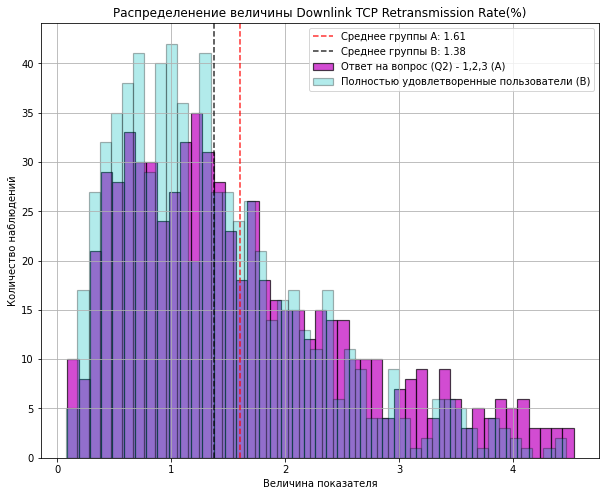

In [147]:
plt.figure(figsize=(10, 8))

plt.hist(df2_2['Downlink TCP Retransmission Rate(%)'], bins=45, facecolor='m', 
             alpha=0.7, edgecolor='black', linewidth=1.2, label='Ответ на вопрос (Q2) - 1,2,3 (A)')
plt.hist(df2_3['Downlink TCP Retransmission Rate(%)'], bins=45, facecolor='c', 
             alpha=0.3, edgecolor='black', linewidth=1.2, label='Полностью удовлетворенные пользователи (B)')
plt.axvline(df2_2['Downlink TCP Retransmission Rate(%)'].mean(), 
            color='red', alpha=0.8,linestyle='dashed', 
            label='Среднее группы A: ' + str(round(df2_2['Downlink TCP Retransmission Rate(%)'].mean(), 2)))

plt.axvline(df2_3['Downlink TCP Retransmission Rate(%)'].mean(), color='black', alpha=0.8,
            linestyle='dashed', 
            label='Среднее группы B: ' + str(round(df2_3['Downlink TCP Retransmission Rate(%)'].mean(), 2)))

plt.grid(True)
plt.xlabel('Величина показателя')
plt.ylabel('Количество наблюдений')
plt.title('Распределенение величины Downlink TCP Retransmission Rate(%)')
plt.legend(loc='upper right')
plt.show
    

Попробуем использовать U-критерий Манна-Уитни.

**U-критерий Манна-Уитни** - это непараметрический критерий статистической значимости для определения того, были ли взяты две независимые выборки из популяции с одинаковым распределением.

Два образца объединяются и ранжируются вместе. Стратегия состоит в том, чтобы определить, являются ли значения из двух выборок случайно смешанными в порядке ранжирования или они объединены в противоположные концы при объединении. Случайный порядок ранга будет означать, что две выборки не отличаются, в то время как кластер значений одной выборки будет указывать на разницу между ними.

Предположение по умолчанию или нулевая гипотеза заключается в том, что нет различий между распределениями выборок данных. Отказ от этой гипотезы позволяет предположить, что между образцами, вероятно, существует некоторое различие. Более конкретно, тест определяет, одинаково ли вероятно, что любое случайно выбранное наблюдение из одной выборки будет больше или меньше, чем выборка из другого распределения. Если нарушено, это предлагает отличающиеся распределения.

Не в состоянии отклонить H0: Распределения выборки равны.
Отклонить H0: Распределения выборки не равны.
Для того чтобы тест был эффективным, требуется не менее 20 наблюдений в каждой выборке данных.

In [148]:
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(df2_2['Downlink TCP Retransmission Rate(%)'].values, 
                       df2_3['Downlink TCP Retransmission Rate(%)'].values)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Одинаковые распределения (Нет оснований отклонить гипотезу H0)')
else:
    print('Разные распределения (Гипотеза H0 отклоняется)')
    

Statistics=205913.500, p=0.000
Разные распределения (Гипотеза H0 отклоняется)


Т.к. размеры выборок не равны, а также количество наблюдений велико (670 и 700), однозначно воспринимать правильность критерия мы не можем

При сумме размеров выборок >60 U-статистика аппроксимируется нормальным распределением

Также мы рассматриваем выборки разного размера, следовательно будем применять бутстреп для генерации выборок одинакового размера

**Рассматривается нулевая гипотеза о равенстве рассматриваемых средних Генеральных совокупностей, 
Альтернативная гипотеза - рассматриваемые средние не равны 
(Предполагается что среднее группы B < среднее группы A, т.к. больше - хуже)**

In [149]:
mean_diff = mean_bc - mean_a # Изначально заданная (имеющаяся) разница
mean_diff


0.22881705756929804

In [150]:
differences = np.zeros((1, 1500)) # Пустой массив для заполнения полученными разницами


In [151]:
confidence = 0.95 
count = 0
intervallist = []
intervallist1 = []


for i in range(0, 1500): # Применение бустрэпа 1500 раз
    s1 = random.choices(df2_2['Downlink TCP Retransmission Rate(%)'].values, k=1000)
    s2 = random.choices(df2_3['Downlink TCP Retransmission Rate(%)'].values, k=1000)
    m1 = np.mean(s1)
    m2 = np.mean(s2)
    n = len(s1)
    se1 =  st.sem(s1)
    se2 = st.sem(s2)
    h1 = se1 * st.t._ppf((1+confidence)/2., n-1)
    h2 = se2 * st.t._ppf((1+confidence)/2., n-1)
    differences[0][i] = m1 - m2
    l1, r1, l2, r2 = round(m1-h1, 3), round(m1+h1, 3), round(m2-h2,3), round(m2+h2, 3) 
    # Левая и правая граница интервалов
    
    if (l2<l1<r2<r1) or (l1<l2<r2<r1) or (l2<l1<r1<r2) or (l1<l2<r1<r2): #пересечение интервалов
        print('Интервал группы A ({},{}) пересекается с группой B ({},{}) '.format(l1,r1,l2,r2)) 
        # Выводим значения интервалов, если они пересекаются
        intervallist.append([m1-h1,m1,m1+h1])
        intervallist1.append([m2-h2,m2,m2+h2])
    if (l2<r2<l1<r1):
        count += 1 # Считаем число случаев, когда доверительный интервал группы B меньше, 
        #чем интервал группы A
        
print('Число случаев, когда интервал группы B левее, чем интервал группы A: ',count)


Интервал группы A (1.475,1.595) пересекается с группой B (1.373,1.481) 
Интервал группы A (1.449,1.569) пересекается с группой B (1.373,1.483) 
Интервал группы A (1.463,1.585) пересекается с группой B (1.371,1.483) 
Интервал группы A (1.465,1.586) пересекается с группой B (1.37,1.481) 
Интервал группы A (1.481,1.606) пересекается с группой B (1.406,1.517) 
Число случаев, когда интервал группы B левее, чем интервал группы A:  1494


Графическое отображение пересекающихся интервалов

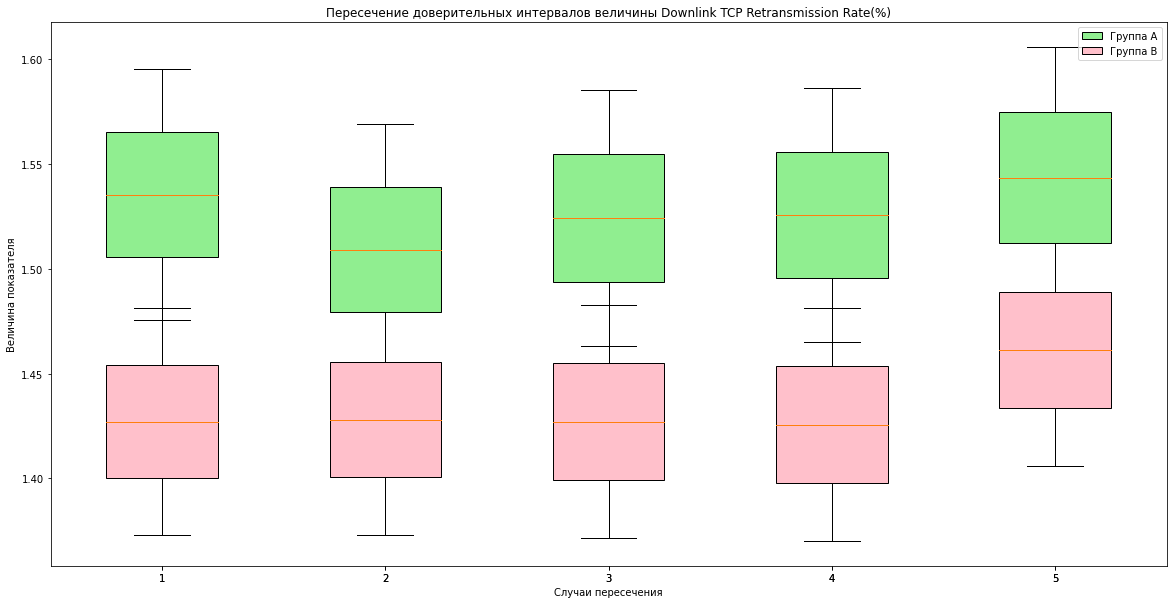

In [152]:
plt.figure(figsize=(20,10))
bp1 = plt.boxplot(intervallist, patch_artist=True)
bp2 = plt.boxplot(intervallist1, patch_artist=True)
for box in bp1['boxes']:
    box.set(facecolor = 'lightgreen')
for box in bp2['boxes']:
    box.set(facecolor = 'pink' )
    
plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Группа A', 'Группа B'], loc='upper right')
plt.xlabel('Случаи пересечения')
plt.ylabel('Величина показателя')
plt.title('Пересечение доверительных интервалов величины Downlink TCP Retransmission Rate(%)')
plt.show()


Даже при таком малом количестве пересечений, можем сделать вывод, что такие пересечения доверительных интервалов незначительные.

In [153]:
((differences - np.mean(differences)) >= mean_diff).sum() 
# В скольких случаях значения центрированного вектора превосходит заданную разницу (p-value)


0

P-value = 0 -> меньше чем любой разумный уровень значимости -> нулевая гипотеза о равенстве средних отклоняется -> Разница есть 

In [154]:
df_diff = pd.DataFrame(differences).transpose() # Датафрейм разницы средних для построения графика
df_diff.columns = ['differences']
df_diff


,differences
0,0.25210
1,0.24758
2,0.19313
3,0.23259
4,0.27980
...,...
1495,0.24981
1496,0.27391
1497,0.27178
1498,0.18298


<function matplotlib.pyplot.show(close=None, block=None)>

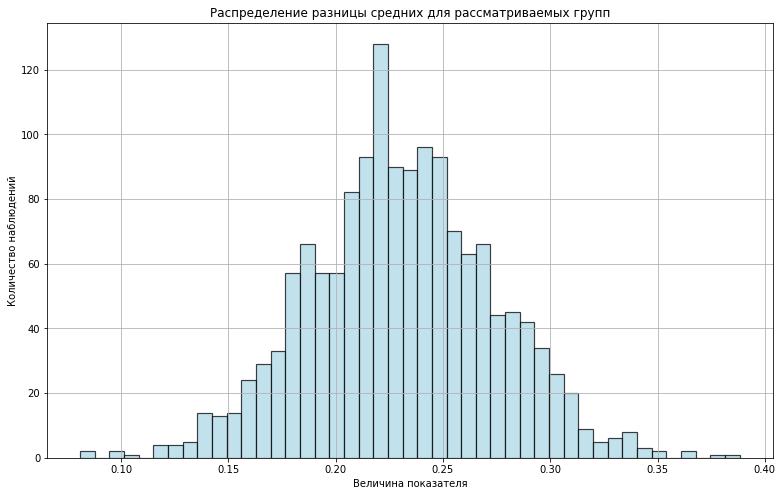

In [155]:
plt.figure(figsize=(13, 8)) # Построение гистограммы полученного распределения
plt.hist(df_diff, bins=45, facecolor='lightblue', alpha=0.75, edgecolor='black', linewidth=1.2)
plt.grid(True)
plt.xlabel('Величина показателя')
plt.ylabel('Количество наблюдений')
plt.title('Распределение разницы средних для рассматриваемых групп')
plt.show

# Распределение напоминает нормальное


Применим Тест Шапиро-Уилка для проверки нулевой гипотезы о том, что выборка разницы средних произошла из нормально распределенной ГС, что позволяет удостовериться в правильности выводов

Нулевая гипотеза - ГС полученной выборки распределена нормально, альтернативная - распределение отличается от нормального

In [156]:
res = st.shapiro((df_diff))
print('p_value: ', res[1])


p_value:  0.40575164556503296


Полученное p_value сильно больше любого допустимого уровня значимости (p = 0.05 в нашем случае) -> Нет оснований отклонить гипотезу о нормальности распределения

**На основании произведенных расчетов и тестов можем сделать вывод, что показатель Downlink TCP Retransmission Rate(%) — частота переотправок пакетов «к абоненту», статистически различается (значимо больше у пользователей рассматриваемой группы A (Q2-1,2,3) ГС, чем у пользоваталей, довольных качеством).**

### Проверяем гипотезу относительно разницы средних показателя Downlink Throughput(Kbps) (средняя скорость «к абоненту») между группами пользоваталей A и B (возьмем совершенно разные аспекты связи, использующие один и тот же показатель) ###



**Группа A - пользователи, ответившие на второй вопрос (Q2) - 3: Плохое качество связи в зданиях, тц и т.д.; Группа B - пользователи, ответившие на второй вопрос (Q2) - 4: Медленный мобильный интернет**

In [157]:
# Рассматриваются независимые наблюдения в двух группах (исключаются повторяющиеся пользователи)

mass = data_Q2[(data_Q2['Q2'] == '3') | (data_Q2['Q2'] == '4')]
indexes = pd.DataFrame(mass['user_id'].value_counts())
indexes = indexes[indexes['user_id'] != 1].index
mass['user_id'] = [np.NaN if elem in indexes else elem for elem in mass['user_id']]
mass = mass.dropna()
mass


,user_id,Group,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Video Streaming Download Throughput(Kbps),Web Page Download Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming xKB Start Delay(ms),Web Average TCP RTT(ms)
1,4,B,8,3,179.18564,2590.97,325.88,7053.81,1221.02,0.80,3218,51
13,11,C,3,3,526.08652,535.54,208.67,2621.14,2376.50,1.46,1479,88
16,19,B,7,3,811.55618,460.32,65.20,1583.27,1587.16,1.50,1340,57
31,50,C,2,3,453.12793,3325.86,167.74,11702.86,2455.82,0.59,1212,40
35,53,B,6,3,168.11047,2031.20,164.31,5234.92,1665.56,0.71,1838,95
...,...,...,...,...,...,...,...,...,...,...,...,...
2705,3095,C,3,3,566.73519,3477.18,124.84,5427.74,2410.91,0.76,1188,145
2718,3101,C,2,4,248.99905,2347.42,309.08,5001.39,1837.79,1.64,1394,83
2719,3102,B,8,4,189.14150,2432.18,72.80,2152.91,1410.52,0.70,2719,289
2727,3108,C,3,4,519.96475,1045.70,44.61,4523.66,1044.66,0.47,1468,304


In [158]:
# Группа A
df3_2 = mass[(mass['Q2'] == '3')]  # Интересующие нас пользователи
df3_2


,user_id,Group,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Video Streaming Download Throughput(Kbps),Web Page Download Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming xKB Start Delay(ms),Web Average TCP RTT(ms)
1,4,B,8,3,179.18564,2590.97,325.88,7053.81,1221.02,0.80,3218,51
13,11,C,3,3,526.08652,535.54,208.67,2621.14,2376.50,1.46,1479,88
16,19,B,7,3,811.55618,460.32,65.20,1583.27,1587.16,1.50,1340,57
31,50,C,2,3,453.12793,3325.86,167.74,11702.86,2455.82,0.59,1212,40
35,53,B,6,3,168.11047,2031.20,164.31,5234.92,1665.56,0.71,1838,95
...,...,...,...,...,...,...,...,...,...,...,...,...
2686,3067,B,5,3,136.63347,1272.06,140.17,2328.40,1248.35,3.16,2647,361
2687,3071,B,8,3,741.69656,498.88,73.80,1201.63,679.58,0.76,3633,251
2688,3073,C,2,3,358.79580,1604.98,223.12,8640.89,1601.76,1.08,1102,70
2705,3095,C,3,3,566.73519,3477.18,124.84,5427.74,2410.91,0.76,1188,145


In [159]:
# Группа B
df3_3 = mass[(mass['Q2'] == '4')]
df3_3


,user_id,Group,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Video Streaming Download Throughput(Kbps),Web Page Download Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming xKB Start Delay(ms),Web Average TCP RTT(ms)
45,67,C,3,4,204.46809,1109.97,100.50,5360.84,1671.27,0.79,1402,136
108,129,C,1,4,641.85847,4410.52,357.93,6230.28,1877.49,1.86,1143,73
112,134,B,7,4,126.95619,3557.73,80.84,7237.32,4717.72,0.30,895,171
136,168,C,1,4,661.11584,1057.29,144.00,5493.31,1615.08,1.57,1346,77
164,202,B,8,4,825.33039,832.71,181.23,2164.55,929.74,3.65,2807,180
...,...,...,...,...,...,...,...,...,...,...,...,...
2691,3077,B,5,4,144.43657,781.40,114.33,4721.98,2530.44,2.07,1608,118
2701,3091,C,2,4,775.73132,420.91,67.61,1981.25,658.33,2.31,2024,266
2718,3101,C,2,4,248.99905,2347.42,309.08,5001.39,1837.79,1.64,1394,83
2719,3102,B,8,4,189.14150,2432.18,72.80,2152.91,1410.52,0.70,2719,289


Построение гистограмм распределений рассматриваемых показателей

<function matplotlib.pyplot.show(close=None, block=None)>

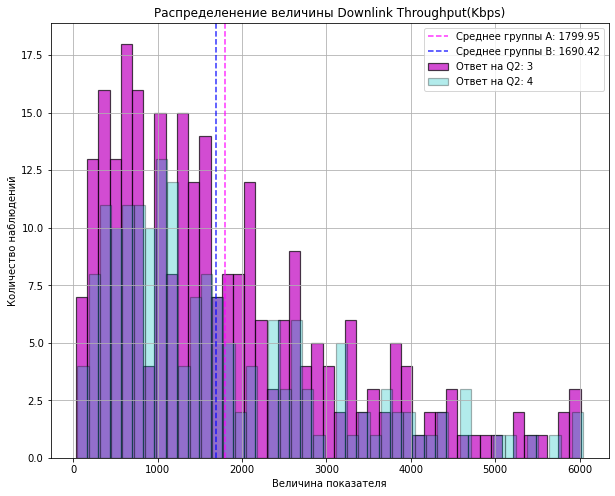

In [160]:
plt.figure(figsize=(10, 8))
plt.hist(df3_2['Downlink Throughput(Kbps)'], bins=45, facecolor='m', 
             alpha=0.7, edgecolor='black', linewidth=1.2, label='Ответ на Q2: 3')
plt.hist(df3_3['Downlink Throughput(Kbps)'], bins=45, facecolor='c', 
             alpha=0.3, edgecolor='black', linewidth=1.2, label='Ответ на Q2: 4')
plt.axvline(df3_2['Downlink Throughput(Kbps)'].mean(), color='magenta', alpha=0.8,
            linestyle='dashed', 
            label='Среднее группы A: ' + str(round(df3_2['Downlink Throughput(Kbps)'].mean(), 2)))

plt.axvline(df3_3['Downlink Throughput(Kbps)'].mean(), color='blue', 
            alpha=0.8,linestyle='dashed', 
            label='Среднее группы B: ' + str(round(df3_3['Downlink Throughput(Kbps)'].mean(), 2)))

plt.grid(True)
plt.xlabel('Величина показателя')
plt.ylabel('Количество наблюдений')
plt.title('Распределенение величины Downlink Throughput(Kbps)')
plt.legend(loc='upper right')
plt.show
    

**U-критерий Манна-Уитни**

Предположение по умолчанию или нулевая гипотеза заключается в том, что нет различий между распределениями выборок данных. Отказ от этой гипотезы позволяет предположить, что между образцами, вероятно, существует некоторое различие.

In [161]:
stat, p = mannwhitneyu(df3_2['Downlink Throughput(Kbps)'].values, 
                       df3_3['Downlink Throughput(Kbps)'].values)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Одинаковые распределения (Нет оснований отклонить гипотезу H0)')
else:
    print('Разные распределения (Гипотеза H0 отклоняется)')
    

Statistics=22214.000, p=0.174
Одинаковые распределения (Нет оснований отклонить гипотезу H0)


Т.к. размеры выборок не равны, а также количество наблюдений велико (443 и 268), однозначно воспринимать правильность критерия мы не можем

Рассматривается нулевая гипотеза о равенстве рассматриваемых средних Генеральных совокупностей, Альтернативная гипотеза - рассматриваемые средние не равны


**Берем наши выборки, делаем по каждой из них бутстреп и проверяем с помощью построения доверительных интервалов, пересекаются ли они, а также генерируем распределние разницы средних.**

In [162]:
mean_bc_2 = df3_2[['Downlink Throughput(Kbps)']].mean()[0]
df3_2[['Downlink Throughput(Kbps)']].mean()


Downlink Throughput(Kbps)    1799.950075
dtype: float64

In [163]:
mean_a_2 = df3_3[['Downlink Throughput(Kbps)']].mean()[0]
df3_3[['Downlink Throughput(Kbps)']].mean()


Downlink Throughput(Kbps)    1690.419371
dtype: float64

In [164]:
mean_diff_2 = np.abs(mean_a_2 - mean_bc_2)
mean_diff_2


109.53070319829408

In [165]:
differences_2 = np.zeros((1, 1500))


In [166]:
confidence = 0.95
count = 0

for i in range(0, 1500):
    s1 = random.choices(df3_2['Downlink Throughput(Kbps)'].values, k=1000)
    s2 = random.choices(df3_3['Downlink Throughput(Kbps)'].values, k=1000)
    m1 = np.mean(s1)
    m2 = np.mean(s2)
    n = len(s1)
    se1 =  st.sem(s1)
    se2 = st.sem(s2)
    h1 = se1 * st.t._ppf((1+confidence)/2., n-1)
    h2 = se2 * st.t._ppf((1+confidence)/2., n-1)
    differences_2[0][i] = m1 - m2
    l1, r1, l2, r2 = m1-h1, m1+h1, m2-h2, m2+h2 # Левая и правая граница интервалов
    if (l1<l2<r1<r2) or (l2<l1<r1<r2) or (l1<l2<r2<r1) or (l2<l1<r2<r1): #пересечение интервалов
        count += 1 # Считаем число случаев пересечения
         
print('Число случаев, когда интервалы пересекаются: ',count)


Число случаев, когда интервалы пересекаются:  1261


In [167]:
((np.abs(differences_2 - np.mean(differences_2)) >= mean_diff_2).sum()) / 1500
# Доля случаев когда центрированная разница больше изначально заданной


0.056

Полученное P-value больше чем P-value = 0.05 при заданном уровне значимости -> нет оснований отклонить нулевую гипотезу о равенстве средних 

In [168]:
df_diff_2 = pd.DataFrame(differences_2 - np.mean(differences_2)).transpose() 
# Датафрейм разницы средних для построения графика
df_diff_2.columns = ['differences']
df_diff_2


,differences
0,66.45932
1,-47.85267
2,-42.92049
3,21.46772
4,-28.01177
...,...
1495,36.75509
1496,-2.70995
1497,97.87428
1498,14.76867


<function matplotlib.pyplot.show(close=None, block=None)>

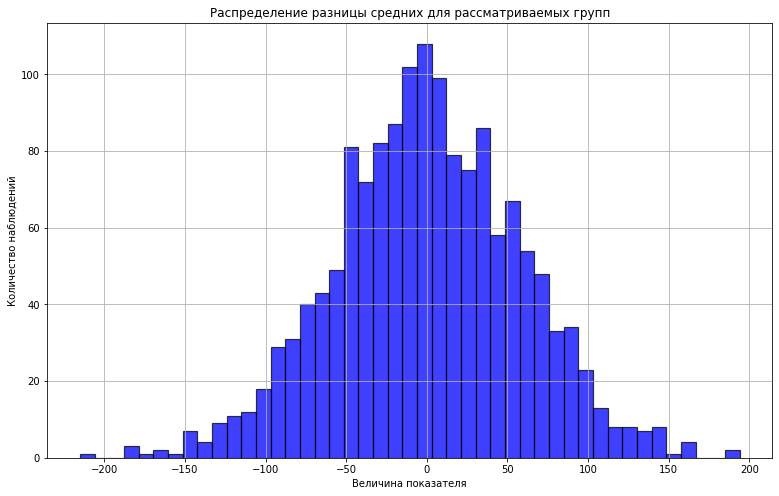

In [169]:
plt.figure(figsize=(13, 8)) # Построение гистограммы полученного распределения
plt.hist(df_diff_2, bins=45, facecolor='blue', alpha=0.75, edgecolor='black', linewidth=1.2)
plt.grid(True)
plt.xlabel('Величина показателя')
plt.ylabel('Количество наблюдений')
plt.title('Распределение разницы средних для рассматриваемых групп')
plt.show

# Распределение напоминает нормальное

Применим Тест Шапиро-Уилка для проверки нулевой гипотезы о том, что выборка разницы средних произошла из нормально распределенной ГС, что позволяет удостовериться в правильности выводов

Нулевая гипотеза - ГС полученной выборки распределена нормально, альтернативная - распределение отличается от нормального

In [170]:
res = st.shapiro((df_diff_2))
print('p_value: ', res[1])

p_value:  0.6409727334976196


Полученное p_value сильно больше рассматриваемого уровня значимости (p = 0.05 в нашем случае) -> Нет оснований отклонить гипотезу о нормальности распределения

**На основании произведенных расчетов и тестов можем сделать вывод, что показатель Downlink Throughput(Kbps)(средняя скорость «к абоненту»), статистически не различается у ГС пользователей ответивших на второй вопрос (Q2) - 3: Плохое качество связи в зданиях, тц и т.д. и пользователей, ответивших на второй вопрос (Q2) - 4: Медленный мобильный интернет**

**Следовательно, следует сравнить данный показатель между разными категориями пользователей - ответивших на вопрос Q2: 3,4 и пользователями ответивших на Q1: 9,10**

### Проверяем гипотезу относительно разницы средних показателя Downlink Throughput(Kbps)(средняя скорость «к абоненту») между группами пользоваталей A и B ###

**Группа A - пользователи, ответившие на второй вопрос (Q2) - 3: Плохое качество связи в зданиях, тц и т.д., 4:Медленный мобильный интернет; Группа B - пользователи, ответившие на первый вопрос (Q1) - 9,10 (полностью удовлетворенные пользователи)**

**Берем наши выборки, делаем по каждой из них бутстреп и проверяем долю случаев когда центрированная разница между средними больше изначально заданной, а также генерируем распределние разницы средних.**

In [171]:
# Группа A
df4_2 = data_Q2[(data_Q2['Q2'] == '3') | (data_Q2['Q2'] == '4')]  # Интересующие нас пользователи
df4_2 = df4_2.drop_duplicates(subset='user_id')  # Устранение повторяющихся пользователей внутри групп
df4_2


,user_id,Group,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Video Streaming Download Throughput(Kbps),Web Page Download Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming xKB Start Delay(ms),Web Average TCP RTT(ms)
1,4,B,8,3,179.18564,2590.97,325.88,7053.81,1221.02,0.80,3218,51
3,5,C,2,3,351.99208,731.61,223.54,4550.38,2336.56,1.15,1767,68
6,9,C,1,3,783.64464,1786.99,271.77,6802.42,1837.02,0.84,1200,132
9,10,C,3,3,455.97369,610.43,81.86,1317.76,1054.15,4.10,3350,165
13,11,C,3,3,526.08652,535.54,208.67,2621.14,2376.50,1.46,1479,88
...,...,...,...,...,...,...,...,...,...,...,...,...
2719,3102,B,8,4,189.14150,2432.18,72.80,2152.91,1410.52,0.70,2719,289
2722,3105,C,1,3,206.28181,105.24,65.84,349.04,1035.69,3.86,2094,267
2727,3108,C,3,4,519.96475,1045.70,44.61,4523.66,1044.66,0.47,1468,304
2730,3109,C,3,3,171.52629,670.32,40.94,1711.54,954.91,2.35,2780,251


In [172]:
# Группа B
df4_3 = data_Q1_Out[data_Q1_Out['Group'] == 'A']
df4_3 = df4_3.drop_duplicates(subset='user_id')  # Устранение повторяющихся пользователей внутри групп
df4_3


,user_id,Group,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Video Streaming Download Throughput(Kbps),Web Page Download Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming xKB Start Delay(ms),Web Average TCP RTT(ms)
15,16,A,10,NaN,767.54725,1729.37,107.94,2490.93,2514.08,1.96,1660,92
21,22,A,10,NaN,601.06519,2135.92,120.55,7215.26,1014.48,1.73,1649,231
25,26,A,10,NaN,360.59845,3743.08,250.93,5943.66,2714.29,0.98,2029,61
27,28,A,10,NaN,373.37642,865.79,82.03,1913.33,1743.42,2.62,2638,122
28,29,A,10,NaN,232.99499,535.05,71.64,1332.35,3421.72,1.07,3548,110
...,...,...,...,...,...,...,...,...,...,...,...,...
3091,3092,A,9,NaN,335.35499,1767.76,104.68,10115.44,462.42,0.38,1234,164
3092,3093,A,10,NaN,758.71809,1512.61,192.21,796.91,216.96,0.87,2567,160
3098,3099,A,10,NaN,343.79289,3469.50,237.13,4559.33,409.40,0.69,1725,150
3105,3106,A,10,NaN,424.34855,2258.16,150.21,5623.82,3480.14,1.56,1313,109


Построение гистограмм распределений рассматриваемых показателей

<function matplotlib.pyplot.show(close=None, block=None)>

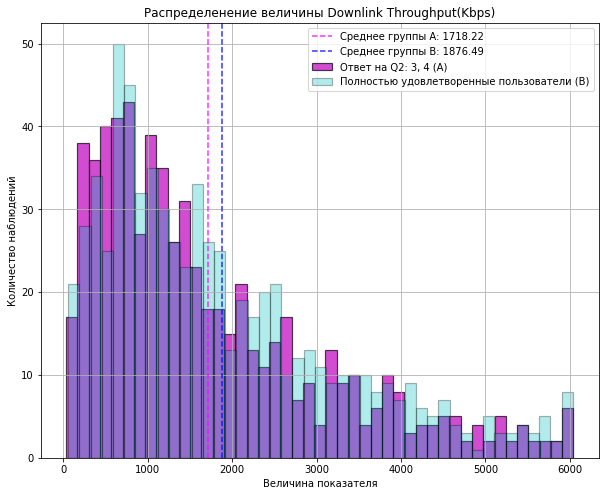

In [173]:
plt.figure(figsize=(10, 8))
plt.hist(df4_2['Downlink Throughput(Kbps)'], bins=45, facecolor='m', 
             alpha=0.7, edgecolor='black', linewidth=1.2, label='Ответ на Q2: 3, 4 (A)')
plt.hist(df4_3['Downlink Throughput(Kbps)'], bins=45, facecolor='c', 
             alpha=0.3, edgecolor='black', linewidth=1.2, 
             label='Полностью удовлетворенные пользователи (B)')
plt.axvline(df4_2['Downlink Throughput(Kbps)'].mean(), color='magenta', 
            alpha=0.8, linestyle='dashed', 
            label='Среднее группы A: ' + str(round(df4_2['Downlink Throughput(Kbps)'].mean(), 2)))

plt.axvline(df4_3['Downlink Throughput(Kbps)'].mean(), color='blue', alpha=0.8,
                linestyle='dashed', 
                label='Среднее группы B: ' + str(round(df4_3['Downlink Throughput(Kbps)'].mean(), 2)))

plt.grid(True)
plt.xlabel('Величина показателя')
plt.ylabel('Количество наблюдений')
plt.title('Распределенение величины Downlink Throughput(Kbps)')
plt.legend(loc='upper right')
plt.show
    

**U-критерий Манна-Уитни**

In [174]:
stat, p = mannwhitneyu(df4_2['Downlink Throughput(Kbps)'].values, 
                       df4_3['Downlink Throughput(Kbps)'].values)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Одинаковые распределения (Нет оснований отклонить гипотезу H0)')
else:
    print('Разные распределения (Гипотеза H0 отклоняется)')
    

Statistics=211844.000, p=0.008
Разные распределения (Гипотеза H0 отклоняется)


Т.к. размеры выборок не равны, а также количество наблюдений велико (655 и 700), однозначно воспринимать правильность критерия мы не можем

Рассматривается нулевая гипотеза о равенстве рассматриваемых средних Генеральных совокупностей, Альтернативная гипотеза - рассматриваемые средние не равны


**Берем наши выборки, делаем по каждой из них бутстреп и проверяем с помощью построения доверительных интервалов, пересекаются ли они, а также генерируем распределние разницы средних.**

In [175]:
mean_bc_3 = df4_2[['Downlink Throughput(Kbps)']].mean()[0]
mean_bc_3


1718.218458015267

In [176]:
mean_a_3 = df4_3[['Downlink Throughput(Kbps)']].mean()[0]
mean_a_3


1876.4857142857143

In [177]:
mean_diff_3 =  np.abs(mean_a_3 - mean_bc_3)
mean_diff_3


158.2672562704472

In [178]:
differences_3 = np.zeros((1, 1500))

In [179]:
confidence = 0.95
count1 = 0
count2 = 0
count3 = 0
count4 = 0

for i in range(0, 1500):
    s1 = random.choices(df4_2['Downlink Throughput(Kbps)'].values, k=1000)
    s2 = random.choices(df4_3['Downlink Throughput(Kbps)'].values, k=1000)
    m1 = np.mean(s1)
    m2 = np.mean(s2)
    n = len(s1)
    se1 =  st.sem(s1)
    se2 = st.sem(s2)
    h1 = se1 * st.t._ppf((1+confidence)/2., n-1)
    h2 = se2 * st.t._ppf((1+confidence)/2., n-1)
    differences_3[0][i] = m2 - m1
    l1, r1, l2, r2 = m1-h1, m1+h1, m2-h2, m2+h2 # Левая и правая граница интервалов
    if (l2<l1<r2<r1) or (l1<l2<r2<r1) or (l2<l1<r1<r2) or (l1<l2<r1<r2): #пересечение интервалов
        count1 += 1 # Выводим значения интервалов, если они пересекаются
        if (m2-m1 > h1) and (m2-m1 > h2) and (m2>m1):
            count4 += 1
    if (l2<r2<l1<r1):
        count2 += 1
    if (l1<r1<l2<r2):
        count3 += 1
        
print ("Число случаев, когда дов. интервалы пересекаются -",count1)
print ("Число случаев, когда разница между средними значима при пересечении интервалов -", count4)
print ("Число случаев, когда интервалы не пересекаются и дов. интервал группы A(Q2) меньше, чем группы B(Q1) -", count3)
print('_________________________________________')
print ("Общая доля случаев, когда дов. интервал группы B больше чем группы A -",(count3 + count4) / 1500)


Число случаев, когда дов. интервалы пересекаются - 847
Число случаев, когда разница между средними значима при пересечении интервалов - 684
Число случаев, когда интервалы не пересекаются и дов. интервал группы A(Q2) меньше, чем группы B(Q1) - 653
_________________________________________
Общая доля случаев, когда дов. интервал группы B больше чем группы A - 0.8913333333333333


In [180]:
((np.abs(differences_3 - np.mean(differences_3)) >= mean_diff_3).sum()) / 1500
# Доля случаев когда центрированная разница больше изначально заданной


0.009333333333333334

Полученное P-value значимо меньше чем P-value = 0.05 при заданном уровне значимости ->  нулевая гипотеза о равенстве средних отклоняется -> Разница есть 

Также учитывая общую долю случаев, когда среднее группы B больше группы A (проверка доверительных интервалов), можем сделать вывод, что среднее ГС данной группы пользователей значимо больше 

In [181]:
df_diff_3 = pd.DataFrame(differences_3 - np.mean(differences_3)).transpose() 
# Датафрейм разницы средних для построения графика
df_diff_3.columns = ['differences']
df_diff_3


,differences
0,77.822839
1,-47.640311
2,-8.221441
3,-34.559991
4,-69.739811
...,...
1495,-51.758101
1496,38.874759
1497,-99.975661
1498,69.580719


<function matplotlib.pyplot.show(close=None, block=None)>

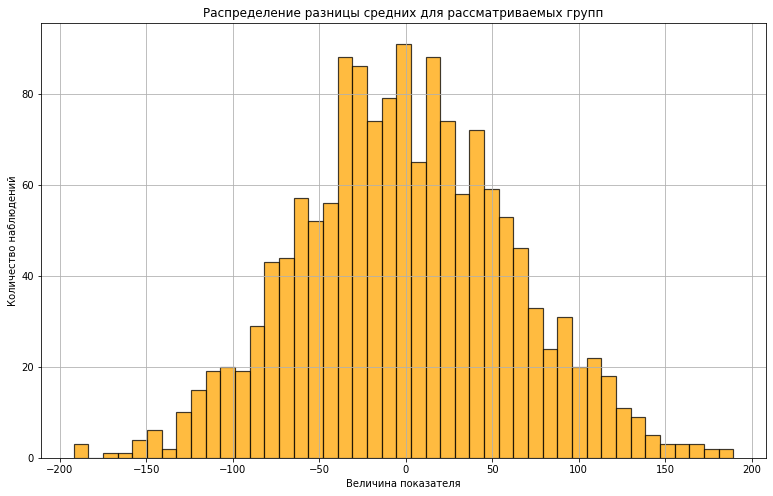

In [182]:
plt.figure(figsize=(13, 8)) # Построение гистограммы полученного распределения
plt.hist(df_diff_3, bins=45, facecolor='orange', alpha=0.75, edgecolor='black', linewidth=1.2)
plt.grid(True)
plt.xlabel('Величина показателя')
plt.ylabel('Количество наблюдений')
plt.title('Распределение разницы средних для рассматриваемых групп')
plt.show

# Распределение напоминает нормальное


Применим Тест Шапиро-Уилка для проверки нулевой гипотезы о том, что выборка разницы средних произошла из нормально распределенной ГС, что позволяет удостовериться в правильности выводов

Нулевая гипотеза - ГС полученной выборки распределена нормально, альтернативная - распределение отличается от нормального

In [183]:
res = st.shapiro((df_diff_3))
print('p_value: ', res[1])


p_value:  0.5684812664985657


Полученное p_value сильно больше любого допустимого уровня значимости (p = 0.05 в нашем случае) -> Нет оснований отклонить гипотезу о нормальности распределения

**На основании произведенных расчетов и тестов можем сделать вывод, что показатель Downlink Throughput(Kbps)(средняя скорость «к абоненту»), статистически различается у ГС пользователей ответивших на второй вопрос (Q2) - 3,4 (3: Плохое качество связи в зданиях, тц и т.д. 4: Медленный мобильный интернет) и пользователей, ответивших на первый вопрос (Q1) - 9,10**

**Так как данный показатель, не отличается внутри групп пользователей ответивших на Q2 - 3 и 4, но статистически различается также между вышеуказанной обобщенной группой и пользователями, полностью довольными качеством связи (у пользователей данной группы значимо выше), можем сделать вывод, что данный показатель влияет на удовлетворённость клиентов и ресурсы на работу с ним направить нужно.**

### Итоги работы. ###

**В ходе исследования были рассмотрены следующие вопросы и сделаны выводы:**

**1) На основании имеющихся данных какое самое вероятное значение доли пользователей, которые полностью довольны качеством связи, и доля пользователей, которые неудовлетворены качеством связи? Каковы доверительные интервалы для этих долей?**

Рассмотрение данного показателя позволяет оценить общую картину исследования, а также удовлетворенности услугами компании "Мегафон" с целью дальнейшего анализа конкретных групп и показателей.

С вероятностью в 95% доля пользователей полностью удовлетворенными качеством связи компании 'Мегафон' лежит в промежутке (0.3375; 0.3714), доля пользоваталей неудовлетворенными качеством связи лежит в промежутке (0.6286; 0.6625).

Делаем вывод, что примерно 2/3 пользователей указали на проблемы со связью, следовательно нужно подробнее разбирать группы пользователей, отвечавших на второй вопрос Q2.

**2) Оценка долей пользователей, которые указали на проблемы по связью (ответы: 1,2,3 на второй вопрос; 1. Недозвоны, обрывы при звонках; 2. Время ожидания гудков при звонке; 3. Плохое качество связи в зданиях, тц и т.д.), относительно всех пользователей**

Рассмотрение данного показателя в первую очередь важно, т.к. компания специализуруется на услугах голосовой связи и большинство пользователей указали на проблему именно с данной составляющей бизнеса.

С вероятностью в 95% доля пользователей, которые указали на проблемы по связью (ответы: 1,2,3; на второй вопрос), относительно всех пользователей компании 'Мегафон' лежит в промежутке (0.3194, 0.3529).

Как мы видим, проблема довольная распространенная, поэтому следут подробнее исследовать показатели качества связи.

На основании дополнительной информации предполагается, что показатели Downlink TCP Retransmission Rate(%) и Downlink Throughput(Kbps) влияют на качество голосовой связи, поэтому далее рассматриваются гипотезы отностительно данных параметров.

**3) Верно ли, что для групп A и B зсредние значения показателя Downlink TCP Retransmission Rate(%) — частота переотправок пакетов «к абоненту» статистически достоверно различаются?**

Рассматривались следующие группы: Группа A - пользователи, ответившие на второй вопрос (Q2) - 1,2,3: 1. Недозвоны, обрывы при звонках; 2. Время ожидания гудков при звонке; 3. Плохое качество связи в зданиях, тц и т.д Группа B - пользователи, ответившие на первый вопрос (Q1) - 9, 10 (отличное качество связи).

На основании произведенных расчетов и тестов можем сделать вывод, что показатель Downlink TCP Retransmission Rate(%) — частота переотправок пакетов «к абоненту», статистически различается (значимо больше у пользователей рассматриваемой группы A (Q2-1,2,3) ГС, чем у пользоваталей, довольных качеством).

В случае рассматриваемого показателя, считается, что чем выше значение, тем хуже. Если в канале возникает ошибка, пакет переотправляется. Снижается полезная скорость.

**4) Верно ли, что для групп A и B средние значения показателя Downlink Throughput(Kbps) (средняя скорость «к абоненту») статистически достоверно различаются?**

Рассматривались следующие группы: Группа A - пользователи, ответившие на второй вопрос (Q2) - 3: Плохое качество связи в зданиях, тц и т.д.; Группа B - пользователи, ответившие на второй вопрос (Q2) - 4: Медленный мобильный интернет.

На основании произведенных расчетов и тестов можем сделать вывод, что показатель Downlink Throughput(Kbps)(средняя скорость «к абоненту»), статистически не различается у ГС рассматриваемых групп (хотя группы довольно различны), следовательно данный показатель одинаков либо плох, либо удовлетворителен (далее в работе мы это выясняем).

**5) Верно ли, что для групп A и B средние значения показателя Downlink Throughput(Kbps) (средняя скорость «к абоненту») статистически достоверно различаются?**

Группа A - пользователи, ответившие на второй вопрос (Q2) - 3: Плохое качество связи в зданиях, тц и т.д., 4:Медленный мобильный интернет; Группа B - пользователи, ответившие на первый вопрос (Q1) - 9,10 (полностью удовлетворенные пользователи).

Данный показатель, не отличается внутри групп пользователей ответивших на Q2 - 3 и 4, однако в ходе исследования удалось выяснить, что данный показатель статистически различается также между вышеуказанной обобщенной группой и пользователями, полностью довольными качеством связи (у пользователей данной группы значимо выше, а значит - лучше).

Дальнейшее исследование предполагает рассмотрение и выявление разницы в показетелях качества связи в группах, связанных с проблемами мобильного интернета/видео, качество которых о в настоящее время является не менее важным, чем качественная голосовая связь.